# NeurIPS Open Polymer Prediction 2025 - Complete Solution

This notebook contains the complete solution for the NeurIPS Open Polymer Prediction 2025 challenge.

## Challenge Overview

- **Task**: Predict 5 polymer properties from SMILES strings
- **Properties**: Tg (glass transition temperature), FFV (fractional free volume), Tc (thermal conductivity), Density, Rg (radius of gyration)
- **Evaluation**: Weighted Mean Absolute Error (wMAE)
- **Data**: 7,973 training samples with significant missing values

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Loading and Exploration](#data)
3. [Molecular Featurization](#featurization)
4. [Dataset Implementation](#dataset)
5. [Model Architecture](#model)
6. [Training Implementation](#training)
7. [Competition Metrics](#metrics)
8. [Training Loop](#training-loop)
9. [Evaluation and Submission](#submission)
10. [Results and Analysis](#results)

## 1. Setup and Imports

First, let's install the required packages and import all necessary libraries.

In [1]:
import os
import sys
import subprocess

# Define required packages
REQUIRED_PACKAGES = [
    "torch",
    "torch-geometric",
    "rdkit-pypi",
    "pandas",
    "numpy",
    "scikit-learn",
    "tqdm",
    "matplotlib",
    "seaborn"
]

# Function to check and install missing packages
def install_and_restart_if_needed(packages):
    import pkg_resources
    missing_packages = []
    for package in packages:
        try:
            # Special handling for package name differences (like rdkit)
            pkg_resources.get_distribution(package if package != "rdkit-pypi" else "rdkit")
        except pkg_resources.DistributionNotFound:
            missing_packages.append(package)
    if missing_packages:
        print(f"Installing missing packages: {missing_packages}")
        # Install with --quiet for a cleaner output, you can drop --quiet if you want detailed logs
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet"] + missing_packages)
        # After installing, force a kernel restart
        os._exit(0)

# Run the installer/restarting code
install_and_restart_if_needed(REQUIRED_PACKAGES)


In [2]:
# Core imports
import os
import sys
import random
import warnings
from datetime import datetime
from typing import List, Dict, Tuple, Optional

# Data handling
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# RDKit for chemistry
from rdkit import Chem
from rdkit.Chem import rdchem
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

All imports successful!
PyTorch version: 2.7.1+cu126
Device available: CPU


In [3]:
# Configuration
class Config:
    """Configuration class for model hyperparameters and settings."""
    
    def __init__(self):
        # Device
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Model hyperparameters
        self.NUM_EPOCHS = 50
        self.BATCH_SIZE = 32
        self.LEARNING_RATE = 1e-3
        self.WEIGHT_DECAY = 1e-5
        self.HIDDEN_CHANNELS = 128
        self.NUM_GCN_LAYERS = 3
        
        # Data
        self.VAL_SPLIT_FRACTION = 0.2
        self.SEED = 42
        
        # Target properties
        self.TARGET_PROPERTIES = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Create configuration instance
CONFIG = Config()

print(f"Configuration:")
print(f"  Device: {CONFIG.DEVICE}")
print(f"  Batch size: {CONFIG.BATCH_SIZE}")
print(f"  Learning rate: {CONFIG.LEARNING_RATE}")
print(f"  Hidden channels: {CONFIG.HIDDEN_CHANNELS}")
print(f"  Target properties: {CONFIG.TARGET_PROPERTIES}")

Configuration:
  Device: cpu
  Batch size: 32
  Learning rate: 0.001
  Hidden channels: 128
  Target properties: ['Tg', 'FFV', 'Tc', 'Density', 'Rg']


In [4]:
# Set random seeds for reproducibility
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(CONFIG.SEED)
print(f"Random seed set to {CONFIG.SEED}")

Random seed set to 42


## 2. Data Loading and Exploration

Let's load the competition data and explore its structure.

In [5]:
# Load competition data
def load_competition_data():
    """Load the competition data files."""
    train_path = "/kaggle/input/neurips-open-polymer-prediction-2025/train.csv"
    test_path = "/kaggle/input/neurips-open-polymer-prediction-2025/test.csv"
    
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Training data not found at {train_path}")
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"Test data not found at {test_path}")
    
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    print(f"Loaded training data: {len(train_df)} samples")
    print(f"Loaded test data: {len(test_df)} samples")
    
    return train_df, test_df

# Load data
train_df, test_df = load_competition_data()

# Display basic info
print("\nTraining data columns:", train_df.columns.tolist())
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Loaded training data: 7973 samples
Loaded test data: 3 samples

Training data columns: ['id', 'SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
Training data shape: (7973, 7)
Test data shape: (3, 2)


In [6]:
# Explore the data
print("First few rows of training data:")
display(train_df.head())

print("\nFirst few rows of test data:")
display(test_df.head())

First few rows of training data:


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN



First few rows of test data:


,id,SMILES
0,1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...
1,1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...
2,2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...


Missing values analysis:
      Tg:  7462/7973 ( 93.6%)
     FFV:   943/7973 ( 11.8%)
      Tc:  7236/7973 ( 90.8%)
 Density:  7360/7973 ( 92.3%)
      Rg:  7359/7973 ( 92.3%)


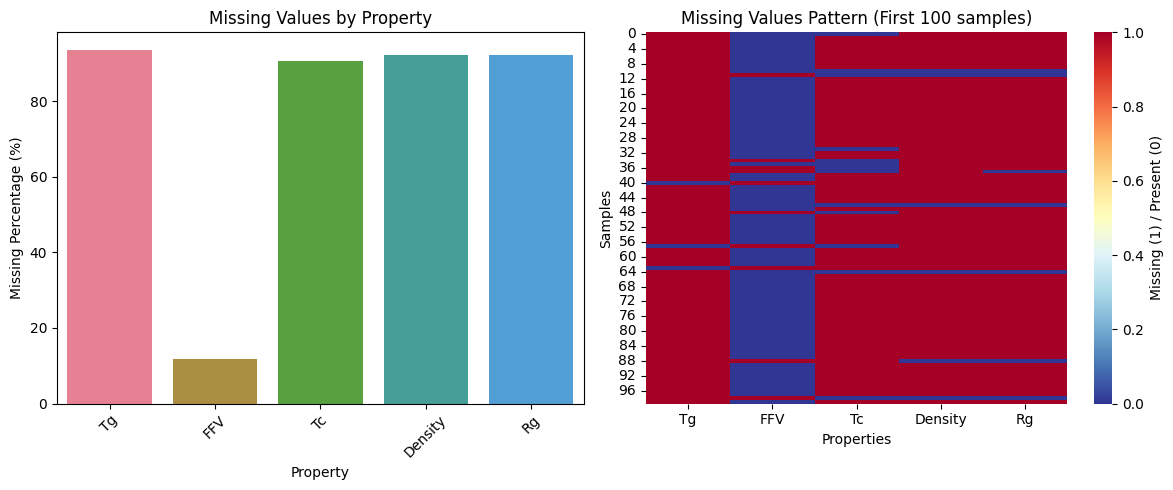

In [7]:
# Analyze missing values
print("Missing values analysis:")
print("=" * 50)

missing_stats = []
for col in CONFIG.TARGET_PROPERTIES:
    if col in train_df.columns:
        missing = train_df[col].isna().sum()
        total = len(train_df)
        percentage = (missing / total) * 100
        missing_stats.append({
            'Property': col,
            'Missing': missing,
            'Total': total,
            'Percentage': percentage
        })
        print(f"{col:>8}: {missing:>5}/{total} ({percentage:>5.1f}%)")

# Create a DataFrame for visualization
missing_df = pd.DataFrame(missing_stats)

# Visualize missing values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=missing_df, x='Property', y='Percentage')
plt.title('Missing Values by Property')
plt.ylabel('Missing Percentage (%)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
# Heatmap of missing values pattern
missing_matrix = train_df[CONFIG.TARGET_PROPERTIES].isna().astype(int)
sns.heatmap(missing_matrix.iloc[:100], cmap='RdYlBu_r', cbar_kws={'label': 'Missing (1) / Present (0)'})
plt.title('Missing Values Pattern (First 100 samples)')
plt.xlabel('Properties')
plt.ylabel('Samples')

plt.tight_layout()
plt.show()

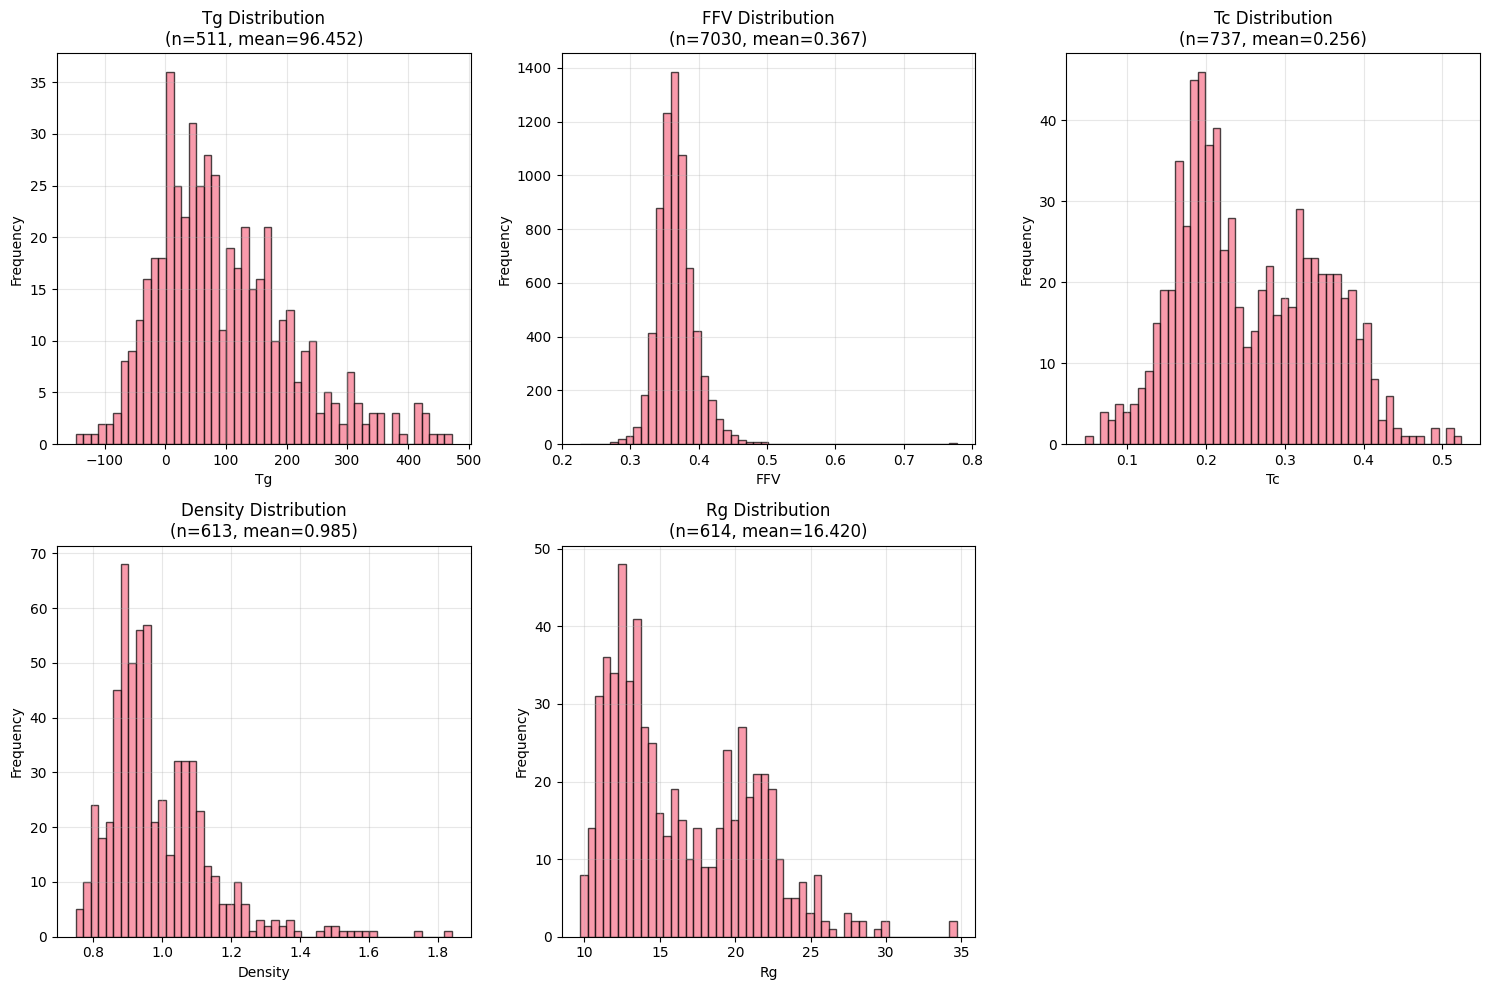


Summary statistics for target properties:


,Tg,FFV,Tc,Density,Rg
count,511.000000,7030.000000,737.000000,613.000000,614.000000
mean,96.452314,0.367212,0.256334,0.985484,16.419787
std,111.228279,0.029609,0.089538,0.146189,4.608640
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,13.674509,0.349549,0.186000,0.890243,12.540328
50%,74.040183,0.364264,0.236000,0.948193,15.052194
75%,161.147595,0.380790,0.330500,1.062096,20.411067
max,472.250000,0.777097,0.524000,1.840999,34.672906


In [8]:
# Analyze property distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, prop in enumerate(CONFIG.TARGET_PROPERTIES):
    if prop in train_df.columns:
        # Remove missing values for plotting
        values = train_df[prop].dropna()
        
        axes[i].hist(values, bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{prop} Distribution\n(n={len(values)}, mean={values.mean():.3f})')
        axes[i].set_xlabel(prop)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary statistics for target properties:")
display(train_df[CONFIG.TARGET_PROPERTIES].describe())

## 3. Molecular Featurization

Convert SMILES strings to graph representations using RDKit.

In [9]:
def get_atom_features(atom):
    """Extract features for a single atom."""
    # Basic atom features
    features = [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetTotalNumHs(),
        atom.GetTotalValence(),
        int(atom.GetIsAromatic()),
        int(atom.GetChiralTag()),
        atom.GetFormalCharge(),
        int(atom.IsInRing()),
    ]
    
    # One-hot encode common atomic numbers in polymers
    common_atoms = [1, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53]  # H, C, N, O, F, Si, P, S, Cl, Br, I
    atomic_num_one_hot = [0] * (len(common_atoms) + 1)  # +1 for "other"
    
    atomic_num = atom.GetAtomicNum()
    if atomic_num in common_atoms:
        atomic_num_one_hot[common_atoms.index(atomic_num)] = 1
    else:
        atomic_num_one_hot[-1] = 1  # "other" category
    
    # Hybridization one-hot encoding
    hybridization_types = [
        rdchem.HybridizationType.SP,
        rdchem.HybridizationType.SP2,
        rdchem.HybridizationType.SP3,
        rdchem.HybridizationType.SP3D,
        rdchem.HybridizationType.SP3D2,
    ]
    hybridization_one_hot = [0] * (len(hybridization_types) + 1)  # +1 for "other"
    
    hybridization = atom.GetHybridization()
    if hybridization in hybridization_types:
        hybridization_one_hot[hybridization_types.index(hybridization)] = 1
    else:
        hybridization_one_hot[-1] = 1
    
    return features + atomic_num_one_hot + hybridization_one_hot


def get_bond_features(bond):
    """Extract features for a single bond."""
    # Bond type one-hot encoding
    bond_types = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC,
    ]
    bond_type_one_hot = [0] * (len(bond_types) + 1)  # +1 for "other"
    
    bond_type = bond.GetBondType()
    if bond_type in bond_types:
        bond_type_one_hot[bond_types.index(bond_type)] = 1
    else:
        bond_type_one_hot[-1] = 1
    
    # Additional bond features
    features = [
        int(bond.IsInRing()),
        int(bond.GetIsConjugated()),
    ]
    
    return features + bond_type_one_hot


def smiles_to_graph(smiles_string: str):
    """Convert a SMILES string to a PyG Data object."""
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        return None
    
    mol = Chem.AddHs(mol)  # Add explicit hydrogens

    # Get atom features
    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    # Get bond features and connectivity
    if mol.GetNumBonds() > 0:
        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices.append((i, j))
            edge_indices.append((j, i))  # Graph must be undirected

            # Enhanced bond features
            bond_features = get_bond_features(bond)
            edge_attrs.append(bond_features)
            edge_attrs.append(bond_features)  # Same features for both directions

        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    else:
        # Handle molecules with no bonds (e.g., single atoms)
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 7), dtype=torch.float)  # 7 bond features

    # Create the PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    # Store number of features for model instantiation later
    data.num_atom_features = x.size(1)

    return data

print("Molecular featurization functions defined!")
print(f"Expected atom feature size: {len(get_atom_features(Chem.MolFromSmiles('C').GetAtomWithIdx(0)))}")

Molecular featurization functions defined!
Expected atom feature size: 26


In [10]:
# Test featurization on a sample SMILES
sample_smiles = train_df['SMILES'].iloc[0]
print(f"Sample SMILES: {sample_smiles}")

sample_graph = smiles_to_graph(sample_smiles)
if sample_graph is not None:
    print(f"Graph created successfully!")
    print(f"  Number of atoms: {sample_graph.x.size(0)}")
    print(f"  Atom feature size: {sample_graph.x.size(1)}")
    print(f"  Number of bonds: {sample_graph.edge_index.size(1) // 2}")
    print(f"  Edge feature size: {sample_graph.edge_attr.size(1) if sample_graph.edge_attr.size(0) > 0 else 0}")
else:
    print("Failed to create graph from SMILES")

# Test on a few more samples to check for failures
print("\nTesting featurization on first 10 SMILES...")
success_count = 0
for i, smiles in enumerate(train_df['SMILES'].head(10)):
    graph = smiles_to_graph(smiles)
    if graph is not None:
        success_count += 1
    else:
        print(f"Failed on sample {i}: {smiles}")

print(f"Success rate: {success_count}/10")

Sample SMILES: *CC(*)c1ccccc1C(=O)OCCCCCC
Graph created successfully!
  Number of atoms: 39
  Atom feature size: 26
  Number of bonds: 39
  Edge feature size: 7

Testing featurization on first 10 SMILES...
Success rate: 10/10


## 4. Dataset Implementation

Create a PyTorch Geometric dataset that handles multi-target prediction and missing values.

In [11]:
class PolymerDataset(Dataset):
    """PyTorch Geometric Dataset for polymer data with multi-target prediction."""

    def __init__(self, df: pd.DataFrame, target_cols: Optional[List[str]] = None, is_test: bool = False):
        super().__init__()
        self.df = df
        self.is_test = is_test
        
        # Default target columns for the competition
        if target_cols is None:
            target_cols = CONFIG.TARGET_PROPERTIES
        self.target_cols = target_cols
        
        self.smiles_list = df['SMILES'].tolist()
        self.ids = df['id'].tolist()
        
        if not is_test:
            # Extract targets and create masks for missing values
            self.targets = []
            self.masks = []
            
            for idx in range(len(df)):
                target_values = []
                mask_values = []
                
                for col in target_cols:
                    if col in df.columns:
                        val = df.iloc[idx][col]
                        if pd.isna(val):
                            target_values.append(0.0)  # Placeholder for missing values
                            mask_values.append(0.0)    # Mask indicates missing
                        else:
                            target_values.append(float(val))
                            mask_values.append(1.0)    # Mask indicates present
                    else:
                        target_values.append(0.0)
                        mask_values.append(0.0)
                
                self.targets.append(target_values)
                self.masks.append(mask_values)
        
        self.cache = {}  # Cache graphs to avoid re-computing

    def len(self):
        return len(self.df)

    def get(self, idx):
        if idx in self.cache:
            data = self.cache[idx]
        else:
            smiles = self.smiles_list[idx]
            data = smiles_to_graph(smiles)
            if data is None:  # Handle RDKit parsing errors
                return None
            self.cache[idx] = data

        # Add ID (store as integer, not tensor)
        data.id = int(self.ids[idx])
        
        if not self.is_test:
            # Add target values and masks - reshape to (1, 5) to preserve structure during batching
            data.y = torch.tensor(self.targets[idx], dtype=torch.float).unsqueeze(0)  # Shape: (1, 5)
            data.mask = torch.tensor(self.masks[idx], dtype=torch.float).unsqueeze(0)  # Shape: (1, 5)
        
        return data

print("PolymerDataset class defined!")

PolymerDataset class defined!


In [12]:
# Test the dataset
print("Testing dataset creation...")

# Create a small test dataset
test_dataset = PolymerDataset(train_df.head(10), is_test=False)
print(f"Dataset length: {len(test_dataset)}")

# Test a single sample
sample = test_dataset.get(0)
if sample is not None:
    print(f"Sample successful:")
    print(f"  ID: {sample.id}")
    print(f"  Node features shape: {sample.x.shape}")
    print(f"  Edge index shape: {sample.edge_index.shape}")
    print(f"  Targets shape: {sample.y.shape}")
    print(f"  Mask shape: {sample.mask.shape}")
    print(f"  Targets: {sample.y.squeeze()}")
    print(f"  Mask: {sample.mask.squeeze()}")
else:
    print("Sample failed")

# Test batching
print("\nTesting data loader...")
loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
for batch in loader:
    print(f"Batch:")
    print(f"  Batch size: {batch.num_graphs}")
    print(f"  Node features shape: {batch.x.shape}")
    print(f"  Targets shape: {batch.y.shape}")
    print(f"  Mask shape: {batch.mask.shape}")
    break

Testing dataset creation...
Dataset length: 10
Sample successful:
  ID: 87817
  Node features shape: torch.Size([39, 26])
  Edge index shape: torch.Size([2, 78])
  Targets shape: torch.Size([1, 5])
  Mask shape: torch.Size([1, 5])
  Targets: tensor([0.0000, 0.3746, 0.2057, 0.0000, 0.0000])
  Mask: tensor([0., 1., 1., 0., 0.])

Testing data loader...
Batch:
  Batch size: 4
  Node features shape: torch.Size([343, 26])
  Targets shape: torch.Size([4, 5])
  Mask shape: torch.Size([4, 5])


## 5. Model Architecture

Implement a Graph Convolutional Network for multi-target polymer property prediction.

In [13]:
class PolymerGCN(nn.Module):
    """Graph Convolutional Network for polymer property prediction."""

    def __init__(self, num_atom_features: int, hidden_channels: int, num_gcn_layers: int):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        # Input layer
        self.convs.append(GCNConv(num_atom_features, hidden_channels))
        self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Hidden layers
        for _ in range(num_gcn_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Output layer for multi-target prediction (5 properties)
        self.out = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 5)  # 5 properties: Tg, FFV, Tc, Density, Rg
        )

    def forward(self, data):
        """Forward pass through the network."""
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Message passing through GCN layers
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)

        # Readout phase: Aggregate node features into a single graph-level representation
        x = global_mean_pool(x, batch)
        
        # Final prediction
        return self.out(x)

print("PolymerGCN model class defined!")

PolymerGCN model class defined!


In [14]:
# Test model creation
print("Testing model creation...")

# Get feature dimensions from a sample
sample_data = test_dataset.get(0)
num_atom_features = sample_data.num_atom_features

# Create model
model = PolymerGCN(
    num_atom_features=num_atom_features,
    hidden_channels=CONFIG.HIDDEN_CHANNELS,
    num_gcn_layers=CONFIG.NUM_GCN_LAYERS
).to(CONFIG.DEVICE)

print(f"Model created successfully!")
print(f"  Input features: {num_atom_features}")
print(f"  Hidden channels: {CONFIG.HIDDEN_CHANNELS}")
print(f"  GCN layers: {CONFIG.NUM_GCN_LAYERS}")
print(f"  Output targets: 5")
print(f"  Device: {CONFIG.DEVICE}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Test forward pass
model.eval()
with torch.no_grad():
    # Create a small batch
    loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
    batch = next(iter(loader))
    batch = batch.to(CONFIG.DEVICE)
    
    output = model(batch)
    print(f"\nForward pass test:")
    print(f"  Input batch size: {batch.num_graphs}")
    print(f"  Output shape: {output.shape}")
    print(f"  Output sample: {output[0].cpu().numpy()}")

Testing model creation...
Model created successfully!
  Input features: 26
  Hidden channels: 128
  GCN layers: 3
  Output targets: 5
  Device: cpu
  Total parameters: 45,829
  Trainable parameters: 45,829

Forward pass test:
  Input batch size: 2
  Output shape: torch.Size([2, 5])
  Output sample: [ 0.0007589   0.1612275  -0.06994595  0.05086089  0.01249845]


## 6. Training Implementation

Implement training functions that handle missing values and multi-target prediction.

In [15]:
def masked_mse_loss(predictions, targets, masks):
    """Calculate MSE loss only for non-missing values."""
    # Ensure all tensors have the same shape
    assert predictions.shape == targets.shape == masks.shape, f"Shape mismatch: pred {predictions.shape}, target {targets.shape}, mask {masks.shape}"
    
    # Only compute loss for non-missing values
    masked_predictions = predictions * masks
    masked_targets = targets * masks
    
    # Calculate squared differences
    squared_diff = (masked_predictions - masked_targets) ** 2
    
    # Sum over all dimensions and divide by number of non-missing values
    total_loss = torch.sum(squared_diff)
    total_count = torch.sum(masks)
    
    if total_count > 0:
        return total_loss / total_count
    else:
        return torch.tensor(0.0, device=predictions.device)


def train_one_epoch(model, loader, optimizer, device):
    """Perform one full training pass over the dataset."""
    model.train()
    total_loss = 0
    total_samples = 0
    
    for data in tqdm(loader, desc="Training", leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        
        out = model(data)
        loss = masked_mse_loss(out, data.y, data.mask)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.num_graphs
        total_samples += data.num_graphs
        
    return total_loss / total_samples


@torch.no_grad()
def evaluate(model, loader, device):
    """Evaluate the model on a dataset."""
    model.eval()
    total_loss = 0
    total_samples = 0
    
    all_preds = []
    all_targets = []
    all_masks = []
    
    for data in tqdm(loader, desc="Evaluating", leave=False):
        data = data.to(device)
        out = model(data)
        
        loss = masked_mse_loss(out, data.y, data.mask)
        total_loss += loss.item() * data.num_graphs
        total_samples += data.num_graphs
        
        all_preds.append(out.cpu())
        all_targets.append(data.y.cpu())
        all_masks.append(data.mask.cpu())

    avg_loss = total_loss / total_samples
    
    # Calculate per-property RMSE
    preds = torch.cat(all_preds, dim=0)  # Shape: (N, 5)
    targets = torch.cat(all_targets, dim=0)  # Shape: (N, 5)
    masks = torch.cat(all_masks, dim=0)  # Shape: (N, 5)
    
    property_names = CONFIG.TARGET_PROPERTIES
    rmses = {}
    
    for i, prop_name in enumerate(property_names):
        prop_mask = masks[:, i]
        if prop_mask.sum() > 0:  # Only calculate if we have non-missing values
            prop_preds = preds[:, i][prop_mask == 1]
            prop_targets = targets[:, i][prop_mask == 1]
            rmse = torch.sqrt(torch.mean((prop_preds - prop_targets) ** 2))
            rmses[prop_name] = rmse.item()
        else:
            rmses[prop_name] = float('nan')
    
    return avg_loss, rmses, (preds.numpy(), targets.numpy(), masks.numpy())


@torch.no_grad()
def predict(model, loader, device):
    """Generate predictions for test data."""
    model.eval()
    all_ids = []
    all_preds = []
    
    for data in tqdm(loader, desc="Predicting", leave=False):
        data = data.to(device)
        out = model(data)
        
        all_ids.extend(data.id)
        all_preds.append(out.cpu())
    
    predictions = torch.cat(all_preds, dim=0).numpy()
    
    return all_ids, predictions

print("Training functions defined!")

Training functions defined!


## 7. Competition Metrics

Implement the competition's weighted MAE metric.

In [16]:
def weighted_mae(predictions, targets, masks=None):
    """Calculate the weighted Mean Absolute Error (wMAE) as defined in the competition."""
    # Convert to numpy if needed
    if torch.is_tensor(predictions):
        predictions = predictions.detach().cpu().numpy()
    if torch.is_tensor(targets):
        targets = targets.detach().cpu().numpy()
    if masks is not None and torch.is_tensor(masks):
        masks = masks.detach().cpu().numpy()
    
    # If no masks provided, assume all values are present
    if masks is None:
        masks = np.ones_like(predictions)
    
    # Calculate weights for each property
    weights = []
    total_samples = predictions.shape[0]
    
    for j in range(5):  # 5 properties
        # Count non-missing values for this property
        N_j = np.sum(masks[:, j])
        
        if N_j == 0:
            weights.append(0.0)
            continue
        
        # Calculate range R_j for this property (using only non-missing values)
        valid_mask = masks[:, j] == 1
        if np.sum(valid_mask) > 1:
            property_values = targets[valid_mask, j]
            R_j = np.max(property_values) - np.min(property_values)
            if R_j == 0:
                R_j = 1.0  # Avoid division by zero
        else:
            R_j = 1.0
        
        # Calculate weight: w_j = (5 / sqrt(N_j)) / R_j
        w_j = (5.0 / np.sqrt(N_j)) / R_j
        weights.append(w_j)
    
    # Normalize weights so they sum to 5
    weights = np.array(weights)
    if np.sum(weights) > 0:
        weights = weights * (5.0 / np.sum(weights))
    
    # Calculate weighted MAE
    total_weighted_error = 0.0
    total_count = 0
    
    for i in range(total_samples):
        for j in range(5):
            if masks[i, j] == 1:  # Only consider non-missing values
                error = abs(predictions[i, j] - targets[i, j])
                weighted_error = weights[j] * error
                total_weighted_error += weighted_error
                total_count += 1
    
    if total_count == 0:
        return float('inf')
    
    wmae = total_weighted_error / total_count
    return wmae


def print_competition_metrics(predictions, targets, masks=None):
    """Print comprehensive metrics in a nice format."""
    wmae = weighted_mae(predictions, targets, masks)
    
    print("\n" + "="*60)
    print("COMPETITION METRICS")
    print("="*60)
    print(f"Weighted MAE (Competition Metric): {wmae:.6f}")
    
    # Per-property metrics
    if masks is None:
        masks = np.ones_like(predictions)
    
    print("\nPer-Property Metrics:")
    print("-"*60)
    print(f"{'Property':<10} {'Count':<8} {'MAE':<12} {'RMSE':<12} {'Range':<12}")
    print("-"*60)
    
    for j, prop_name in enumerate(CONFIG.TARGET_PROPERTIES):
        valid_mask = masks[:, j] == 1
        count = np.sum(valid_mask)
        
        if count > 0:
            pred_vals = predictions[valid_mask, j]
            true_vals = targets[valid_mask, j]
            
            mae = np.mean(np.abs(pred_vals - true_vals))
            rmse = np.sqrt(np.mean((pred_vals - true_vals) ** 2))
            prop_range = np.max(true_vals) - np.min(true_vals) if len(true_vals) > 1 else 0.0
            
            print(f"{prop_name:<10} {count:<8} {mae:<12.6f} {rmse:<12.6f} {prop_range:<12.6f}")
        else:
            print(f"{prop_name:<10} {count:<8} {'N/A':<12} {'N/A':<12} {'N/A':<12}")
    
    print("="*60)

print("Competition metrics functions defined!")

Competition metrics functions defined!


## 8. Data Preparation and Training Loop

Prepare the datasets and train the model.

In [17]:
# Prepare datasets
def prepare_datasets(train_df, test_df, val_split=0.2):
    """Prepare datasets for training, validation, and testing."""
    # Create datasets
    full_train_dataset = PolymerDataset(train_df, is_test=False)
    test_dataset = PolymerDataset(test_df, is_test=True)
    
    # Filter out invalid SMILES from training data
    valid_indices = []
    print("Filtering invalid SMILES...")
    for i in tqdm(range(len(full_train_dataset))):
        data = full_train_dataset.get(i)
        if data is not None:
            valid_indices.append(i)
    
    if len(valid_indices) != len(full_train_dataset):
        print(f"Warning: Filtered out {len(full_train_dataset) - len(valid_indices)} invalid SMILES from training data.")
    
    # Create clean training dataset
    train_df_clean = train_df.iloc[valid_indices].reset_index(drop=True)
    clean_train_dataset = PolymerDataset(train_df_clean, is_test=False)
    
    # Split training data into train and validation
    train_size = int((1.0 - val_split) * len(clean_train_dataset))
    val_size = len(clean_train_dataset) - train_size
    train_dataset, val_dataset = random_split(clean_train_dataset, [train_size, val_size])
    
    print(f"\nDataset sizes:")
    print(f"  Training: {len(train_dataset)}")
    print(f"  Validation: {len(val_dataset)}")
    print(f"  Test: {len(test_dataset)}")
    
    return train_dataset, val_dataset, test_dataset

# Prepare datasets
train_dataset, val_dataset, test_dataset = prepare_datasets(
    train_df, test_df, val_split=CONFIG.VAL_SPLIT_FRACTION
)

Filtering invalid SMILES...


100%|██████████| 7973/7973 [00:18<00:00, 434.89it/s]



Dataset sizes:
  Training: 6378
  Validation: 1595
  Test: 3


In [18]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Get feature dimensions
first_data = train_dataset[0]
num_atom_features = first_data.num_atom_features
print(f"  Atom features: {num_atom_features}")

Data loaders created:
  Train batches: 200
  Val batches: 50
  Test batches: 1
  Atom features: 26


In [19]:
# Initialize model, optimizer, and scheduler
model = PolymerGCN(
    num_atom_features=num_atom_features,
    hidden_channels=CONFIG.HIDDEN_CHANNELS,
    num_gcn_layers=CONFIG.NUM_GCN_LAYERS
).to(CONFIG.DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=CONFIG.LEARNING_RATE,
    weight_decay=CONFIG.WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"Model initialized:")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Device: {CONFIG.DEVICE}")

Model initialized:
  Parameters: 45,829
  Device: cpu


In [20]:
# Training loop
print(f"Starting training for {CONFIG.NUM_EPOCHS} epochs...")
print("="*80)

# Training history
history = {
    'train_losses': [],
    'val_losses': [],
    'val_rmses': [],
    'learning_rates': [],
    'wmae_scores': []
}

best_val_loss = float('inf')
best_wmae = float('inf')
patience_counter = 0
early_stopping_patience = 15

for epoch in range(1, CONFIG.NUM_EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, CONFIG.DEVICE)
    history['train_losses'].append(train_loss)
    
    # Validate
    val_loss, val_rmses, (val_preds, val_targets, val_masks) = evaluate(model, val_loader, CONFIG.DEVICE)
    history['val_losses'].append(val_loss)
    history['val_rmses'].append(val_rmses)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    # Calculate competition metric
    wmae = weighted_mae(val_preds, val_targets, val_masks)
    history['wmae_scores'].append(wmae)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print progress
    rmse_str = ", ".join([f"{k}: {v:.4f}" for k, v in val_rmses.items() if not np.isnan(v)])
    print(f"Epoch {epoch:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | wMAE: {wmae:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"         RMSE: {rmse_str}")
    
    # Save best model
    if wmae < best_wmae:
        best_wmae = wmae
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save model state
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'wmae': wmae,
            'val_rmses': val_rmses,
        }, 'best_model.pt')
        
        print(f"         -> New best wMAE! Model saved.")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {patience_counter} epochs without improvement.")
        break
    
    print("-" * 80)

print(f"\nTraining complete!")
print(f"Best validation wMAE: {best_wmae:.6f}")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training for 50 epochs...


Epoch   1 | Train: 813.6330 | Val: 395.2308 | wMAE: 0.259267 | LR: 0.001000
         RMSE: Tg: 82.4199, FFV: 0.1891, Tc: 0.3192, Density: 0.7662, Rg: 22.1691
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch   2 | Train: 382.3332 | Val: 262.2967 | wMAE: 0.114738 | LR: 0.001000
         RMSE: Tg: 68.9553, FFV: 0.1219, Tc: 0.1154, Density: 0.1711, Rg: 10.2628
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch   3 | Train: 313.5379 | Val: 307.3582 | wMAE: 0.151781 | LR: 0.001000
         RMSE: Tg: 75.8097, FFV: 0.1424, Tc: 0.1211, Density: 0.5038, Rg: 6.8809
--------------------------------------------------------------------------------


Epoch   4 | Train: 296.0751 | Val: 315.9870 | wMAE: 0.090550 | LR: 0.001000
         RMSE: Tg: 76.6288, FFV: 0.0949, Tc: 0.0852, Density: 0.2647, Rg: 5.9425
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch   5 | Train: 286.8471 | Val: 238.0618 | wMAE: 0.075592 | LR: 0.001000
         RMSE: Tg: 66.6383, FFV: 0.0647, Tc: 0.1155, Density: 0.2374, Rg: 5.3091
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch   6 | Train: 293.6700 | Val: 247.7547 | wMAE: 0.078403 | LR: 0.001000
         RMSE: Tg: 67.8128, FFV: 0.0682, Tc: 0.0731, Density: 0.2850, Rg: 4.3061
--------------------------------------------------------------------------------


Epoch   7 | Train: 287.0468 | Val: 289.6851 | wMAE: 0.061052 | LR: 0.001000
         RMSE: Tg: 73.8098, FFV: 0.0405, Tc: 0.0797, Density: 0.1824, Rg: 5.1079
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch   8 | Train: 298.4297 | Val: 248.5966 | wMAE: 0.057254 | LR: 0.001000
         RMSE: Tg: 67.8334, FFV: 0.0674, Tc: 0.0685, Density: 0.1629, Rg: 3.8396
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch   9 | Train: 265.0358 | Val: 306.1214 | wMAE: 0.080778 | LR: 0.001000
         RMSE: Tg: 74.2516, FFV: 0.0948, Tc: 0.0805, Density: 0.1708, Rg: 5.2800
--------------------------------------------------------------------------------


Epoch  10 | Train: 273.3604 | Val: 239.9528 | wMAE: 0.072400 | LR: 0.001000
         RMSE: Tg: 66.7039, FFV: 0.0426, Tc: 0.1475, Density: 0.2212, Rg: 4.7660
--------------------------------------------------------------------------------


Epoch  11 | Train: 259.3173 | Val: 236.6659 | wMAE: 0.101602 | LR: 0.001000
         RMSE: Tg: 65.8115, FFV: 0.1372, Tc: 0.0916, Density: 0.1565, Rg: 4.9116
--------------------------------------------------------------------------------


Epoch  12 | Train: 263.3342 | Val: 221.4969 | wMAE: 0.065142 | LR: 0.001000
         RMSE: Tg: 63.8812, FFV: 0.0519, Tc: 0.0851, Density: 0.1961, Rg: 4.4880
--------------------------------------------------------------------------------


Epoch  13 | Train: 260.5765 | Val: 250.2504 | wMAE: 0.061703 | LR: 0.001000
         RMSE: Tg: 68.5916, FFV: 0.0418, Tc: 0.0662, Density: 0.2155, Rg: 5.0952
--------------------------------------------------------------------------------


Epoch  14 | Train: 255.4253 | Val: 216.9821 | wMAE: 0.063351 | LR: 0.001000
         RMSE: Tg: 63.2993, FFV: 0.0444, Tc: 0.0854, Density: 0.2035, Rg: 4.5865
--------------------------------------------------------------------------------


Epoch  15 | Train: 255.1575 | Val: 228.0698 | wMAE: 0.072604 | LR: 0.001000
         RMSE: Tg: 64.6809, FFV: 0.0746, Tc: 0.0898, Density: 0.1935, Rg: 4.3126
--------------------------------------------------------------------------------


Epoch  16 | Train: 253.7677 | Val: 214.9082 | wMAE: 0.072852 | LR: 0.001000
         RMSE: Tg: 63.0644, FFV: 0.0678, Tc: 0.0827, Density: 0.2256, Rg: 5.3025
--------------------------------------------------------------------------------


Epoch  17 | Train: 260.2576 | Val: 235.0402 | wMAE: 0.065056 | LR: 0.001000
         RMSE: Tg: 66.0701, FFV: 0.0571, Tc: 0.0814, Density: 0.2056, Rg: 4.2431
--------------------------------------------------------------------------------


Epoch  18 | Train: 253.0340 | Val: 235.2166 | wMAE: 0.055747 | LR: 0.001000
         RMSE: Tg: 65.9822, FFV: 0.0393, Tc: 0.0883, Density: 0.1798, Rg: 4.2187
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch  19 | Train: 231.8172 | Val: 229.0007 | wMAE: 0.078117 | LR: 0.001000
         RMSE: Tg: 65.3316, FFV: 0.0447, Tc: 0.1277, Density: 0.3082, Rg: 4.5715
--------------------------------------------------------------------------------


Epoch  20 | Train: 233.5862 | Val: 223.4841 | wMAE: 0.063494 | LR: 0.001000
         RMSE: Tg: 64.1800, FFV: 0.0430, Tc: 0.1226, Density: 0.1795, Rg: 4.7589
--------------------------------------------------------------------------------


Epoch  21 | Train: 232.0964 | Val: 243.9225 | wMAE: 0.073217 | LR: 0.001000
         RMSE: Tg: 67.4228, FFV: 0.0790, Tc: 0.0695, Density: 0.1837, Rg: 4.4421
--------------------------------------------------------------------------------


Epoch  22 | Train: 236.0856 | Val: 238.8247 | wMAE: 0.069293 | LR: 0.000500
         RMSE: Tg: 66.8734, FFV: 0.0435, Tc: 0.0939, Density: 0.2499, Rg: 4.1993
--------------------------------------------------------------------------------


Epoch  23 | Train: 229.2418 | Val: 247.2998 | wMAE: 0.051917 | LR: 0.000500
         RMSE: Tg: 67.9971, FFV: 0.0396, Tc: 0.0620, Density: 0.1739, Rg: 3.9432
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch  24 | Train: 225.2586 | Val: 226.4891 | wMAE: 0.060208 | LR: 0.000500
         RMSE: Tg: 64.8291, FFV: 0.0394, Tc: 0.0721, Density: 0.2397, Rg: 4.0618
--------------------------------------------------------------------------------


Epoch  25 | Train: 223.8732 | Val: 233.3686 | wMAE: 0.059336 | LR: 0.000500
         RMSE: Tg: 65.9610, FFV: 0.0546, Tc: 0.0706, Density: 0.1787, Rg: 4.1428
--------------------------------------------------------------------------------


Epoch  26 | Train: 227.8746 | Val: 224.8080 | wMAE: 0.058887 | LR: 0.000500
         RMSE: Tg: 64.1199, FFV: 0.0445, Tc: 0.0799, Density: 0.2029, Rg: 3.7423
--------------------------------------------------------------------------------


Epoch  27 | Train: 216.2082 | Val: 228.8699 | wMAE: 0.068349 | LR: 0.000500
         RMSE: Tg: 65.2006, FFV: 0.0519, Tc: 0.1142, Density: 0.1835, Rg: 4.1236
--------------------------------------------------------------------------------


Epoch  28 | Train: 214.7539 | Val: 214.6848 | wMAE: 0.055762 | LR: 0.000500
         RMSE: Tg: 62.7966, FFV: 0.0460, Tc: 0.0828, Density: 0.1828, Rg: 4.0135
--------------------------------------------------------------------------------


Epoch  29 | Train: 207.9017 | Val: 219.2698 | wMAE: 0.061443 | LR: 0.000500
         RMSE: Tg: 63.6920, FFV: 0.0329, Tc: 0.1048, Density: 0.2204, Rg: 4.1281
--------------------------------------------------------------------------------


Epoch  30 | Train: 233.8482 | Val: 250.9447 | wMAE: 0.057513 | LR: 0.000500
         RMSE: Tg: 68.1762, FFV: 0.0395, Tc: 0.0799, Density: 0.1972, Rg: 4.6273
--------------------------------------------------------------------------------


Epoch  31 | Train: 211.8177 | Val: 231.7111 | wMAE: 0.061219 | LR: 0.000500
         RMSE: Tg: 65.2263, FFV: 0.0447, Tc: 0.0890, Density: 0.1885, Rg: 4.1630
--------------------------------------------------------------------------------


Epoch  32 | Train: 213.1828 | Val: 224.4614 | wMAE: 0.054338 | LR: 0.000500
         RMSE: Tg: 64.4024, FFV: 0.0357, Tc: 0.0731, Density: 0.2102, Rg: 4.1678
--------------------------------------------------------------------------------


Epoch  33 | Train: 214.5144 | Val: 266.4823 | wMAE: 0.054120 | LR: 0.000500
         RMSE: Tg: 70.4706, FFV: 0.0331, Tc: 0.0799, Density: 0.1924, Rg: 4.8715
--------------------------------------------------------------------------------


Epoch  34 | Train: 210.9359 | Val: 221.9449 | wMAE: 0.064109 | LR: 0.000250
         RMSE: Tg: 63.9849, FFV: 0.0381, Tc: 0.0738, Density: 0.2804, Rg: 4.4425
--------------------------------------------------------------------------------


Epoch  35 | Train: 203.1018 | Val: 233.7313 | wMAE: 0.057335 | LR: 0.000250
         RMSE: Tg: 65.1926, FFV: 0.0505, Tc: 0.0707, Density: 0.1806, Rg: 3.9442
--------------------------------------------------------------------------------


Epoch  36 | Train: 209.0571 | Val: 228.1901 | wMAE: 0.051757 | LR: 0.000250
         RMSE: Tg: 64.5308, FFV: 0.0332, Tc: 0.0849, Density: 0.1762, Rg: 4.1966
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch  37 | Train: 202.3237 | Val: 232.9196 | wMAE: 0.049774 | LR: 0.000250
         RMSE: Tg: 65.2327, FFV: 0.0325, Tc: 0.0674, Density: 0.1823, Rg: 4.3274
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch  38 | Train: 209.1459 | Val: 232.6431 | wMAE: 0.054295 | LR: 0.000250
         RMSE: Tg: 65.5644, FFV: 0.0366, Tc: 0.0786, Density: 0.1903, Rg: 4.4121
--------------------------------------------------------------------------------


Epoch  39 | Train: 203.6742 | Val: 238.9954 | wMAE: 0.048804 | LR: 0.000250
         RMSE: Tg: 66.5959, FFV: 0.0333, Tc: 0.0721, Density: 0.1768, Rg: 4.3610
         -> New best wMAE! Model saved.
--------------------------------------------------------------------------------


Epoch  40 | Train: 207.5021 | Val: 226.4342 | wMAE: 0.070337 | LR: 0.000125
         RMSE: Tg: 64.2947, FFV: 0.0378, Tc: 0.1577, Density: 0.2146, Rg: 4.2999
--------------------------------------------------------------------------------


Epoch  41 | Train: 206.7294 | Val: 231.7644 | wMAE: 0.054613 | LR: 0.000125
         RMSE: Tg: 65.0042, FFV: 0.0361, Tc: 0.0880, Density: 0.1744, Rg: 4.4103
--------------------------------------------------------------------------------


Epoch  42 | Train: 200.6895 | Val: 229.4339 | wMAE: 0.050403 | LR: 0.000125
         RMSE: Tg: 64.7097, FFV: 0.0314, Tc: 0.0728, Density: 0.1897, Rg: 4.4295
--------------------------------------------------------------------------------


Epoch  43 | Train: 206.9550 | Val: 225.9074 | wMAE: 0.049322 | LR: 0.000125
         RMSE: Tg: 64.2957, FFV: 0.0327, Tc: 0.0708, Density: 0.1789, Rg: 4.4558
--------------------------------------------------------------------------------


Epoch  44 | Train: 197.4350 | Val: 231.7944 | wMAE: 0.051099 | LR: 0.000125
         RMSE: Tg: 65.1560, FFV: 0.0342, Tc: 0.0774, Density: 0.1840, Rg: 4.5580
--------------------------------------------------------------------------------


Epoch  45 | Train: 195.2818 | Val: 227.9791 | wMAE: 0.052838 | LR: 0.000125
         RMSE: Tg: 64.4593, FFV: 0.0369, Tc: 0.0812, Density: 0.1940, Rg: 4.6823
--------------------------------------------------------------------------------


Epoch  46 | Train: 192.6604 | Val: 230.6472 | wMAE: 0.052789 | LR: 0.000063
         RMSE: Tg: 65.0112, FFV: 0.0350, Tc: 0.0766, Density: 0.1929, Rg: 4.5278
--------------------------------------------------------------------------------


Epoch  47 | Train: 191.9796 | Val: 232.2475 | wMAE: 0.050456 | LR: 0.000063
         RMSE: Tg: 64.9647, FFV: 0.0334, Tc: 0.0771, Density: 0.1810, Rg: 4.4901
--------------------------------------------------------------------------------


Epoch  48 | Train: 192.1336 | Val: 229.1860 | wMAE: 0.053350 | LR: 0.000063
         RMSE: Tg: 64.7445, FFV: 0.0343, Tc: 0.0863, Density: 0.1884, Rg: 4.5894
--------------------------------------------------------------------------------


Epoch  49 | Train: 198.3798 | Val: 235.3272 | wMAE: 0.052319 | LR: 0.000063
         RMSE: Tg: 65.4025, FFV: 0.0359, Tc: 0.0800, Density: 0.1804, Rg: 4.7330
--------------------------------------------------------------------------------


Epoch  50 | Train: 187.1409 | Val: 233.6630 | wMAE: 0.052183 | LR: 0.000063
         RMSE: Tg: 65.3601, FFV: 0.0337, Tc: 0.0810, Density: 0.1960, Rg: 4.8340
--------------------------------------------------------------------------------

Training complete!
Best validation wMAE: 0.048804
Best validation loss: 238.9954


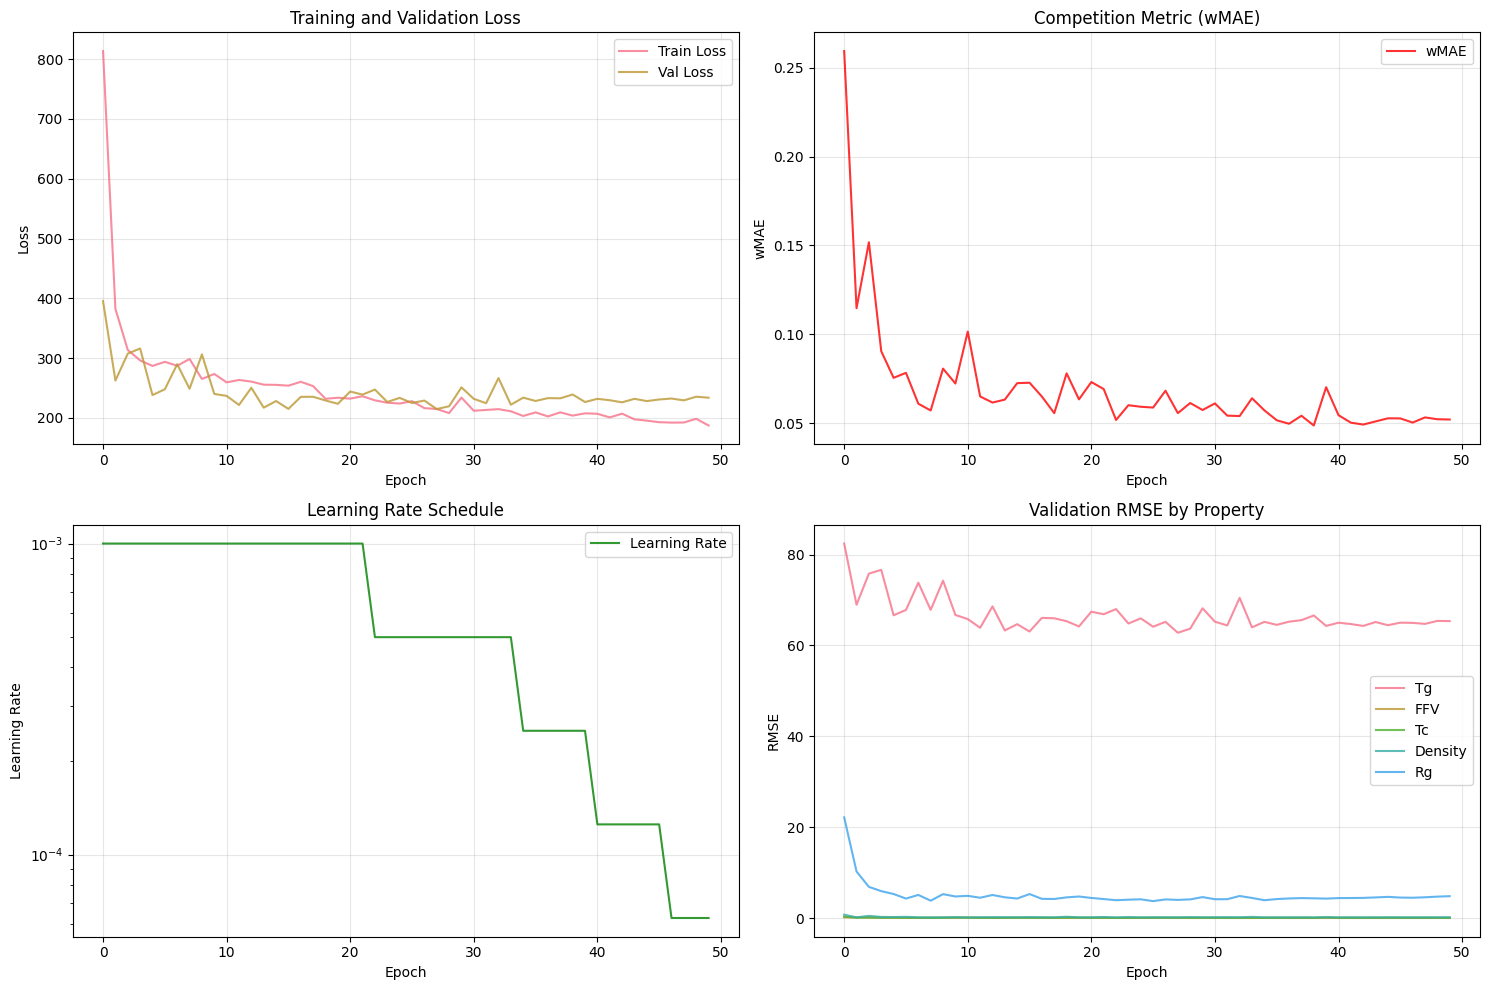

In [21]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training and validation loss
axes[0, 0].plot(history['train_losses'], label='Train Loss', alpha=0.8)
axes[0, 0].plot(history['val_losses'], label='Val Loss', alpha=0.8)
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Competition metric (wMAE)
axes[0, 1].plot(history['wmae_scores'], label='wMAE', color='red', alpha=0.8)
axes[0, 1].set_title('Competition Metric (wMAE)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('wMAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
axes[1, 0].plot(history['learning_rates'], label='Learning Rate', color='green', alpha=0.8)
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# RMSE by property
for prop in CONFIG.TARGET_PROPERTIES:
    rmse_values = [rmse_dict.get(prop, np.nan) for rmse_dict in history['val_rmses']]
    # Only plot if we have valid values
    if not all(np.isnan(rmse_values)):
        axes[1, 1].plot(rmse_values, label=prop, alpha=0.8)

axes[1, 1].set_title('Validation RMSE by Property')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Evaluation and Submission

Load the best model and generate predictions for the test set.

In [22]:
# Load the best model
print("Loading best model...")
checkpoint = torch.load('best_model.pt', map_location=CONFIG.DEVICE, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Best model loaded:")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"  Competition wMAE: {checkpoint['wmae']:.6f}")

# Final evaluation on validation set
print("\nFinal validation evaluation:")
val_loss, val_rmses, (val_preds, val_targets, val_masks) = evaluate(model, val_loader, CONFIG.DEVICE)
print_competition_metrics(val_preds, val_targets, val_masks)

Loading best model...
Best model loaded:
  Epoch: 39
  Validation Loss: 238.9954
  Competition wMAE: 0.048804

Final validation evaluation:



COMPETITION METRICS
Weighted MAE (Competition Metric): 0.048804

Per-Property Metrics:
------------------------------------------------------------
Property   Count    MAE          RMSE         Range       
------------------------------------------------------------
Tg         105      51.477654    66.595909    585.519714  
FFV        1413     0.022369     0.033284     0.517487    
Tc         137      0.048724     0.072119     0.438000    
Density    118      0.119533     0.176762     0.606176    
Rg         118      3.202042     4.361005     23.877449   


In [23]:
# Generate predictions for test set
print("Generating predictions for test set...")
test_ids, test_predictions = predict(model, test_loader, CONFIG.DEVICE)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': [int(id_val) if hasattr(id_val, 'item') else int(id_val) for id_val in test_ids],
    'Tg': test_predictions[:, 0],
    'FFV': test_predictions[:, 1],
    'Tc': test_predictions[:, 2],
    'Density': test_predictions[:, 3],
    'Rg': test_predictions[:, 4]
})

# Save submission
submission_filename = f"submission.csv"
submission_df.to_csv(submission_filename, index=False)

print(f"\nSubmission saved to: {submission_filename}")
print(f"Submission shape: {submission_df.shape}")
print("\nSample predictions:")
display(submission_df.head())

# Verify submission format
expected_columns = ['id', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
if list(submission_df.columns) == expected_columns:
    print("✅ Submission format is correct!")
else:
    print("❌ Submission format is incorrect!")
    print(f"Expected: {expected_columns}")
    print(f"Got: {list(submission_df.columns)}")

Generating predictions for test set...



Submission saved to: submission.csv
Submission shape: (3, 6)

Sample predictions:


,id,Tg,FFV,Tc,Density,Rg
0,1109053969,105.922157,0.342731,0.227137,0.971571,13.312989
1,1422188626,125.035744,0.362379,0.209780,0.974391,12.585095
2,2032016830,125.428688,0.348131,0.290806,1.108855,17.978243


✅ Submission format is correct!


## 10. Results and Analysis

Analyze the model performance and predictions.

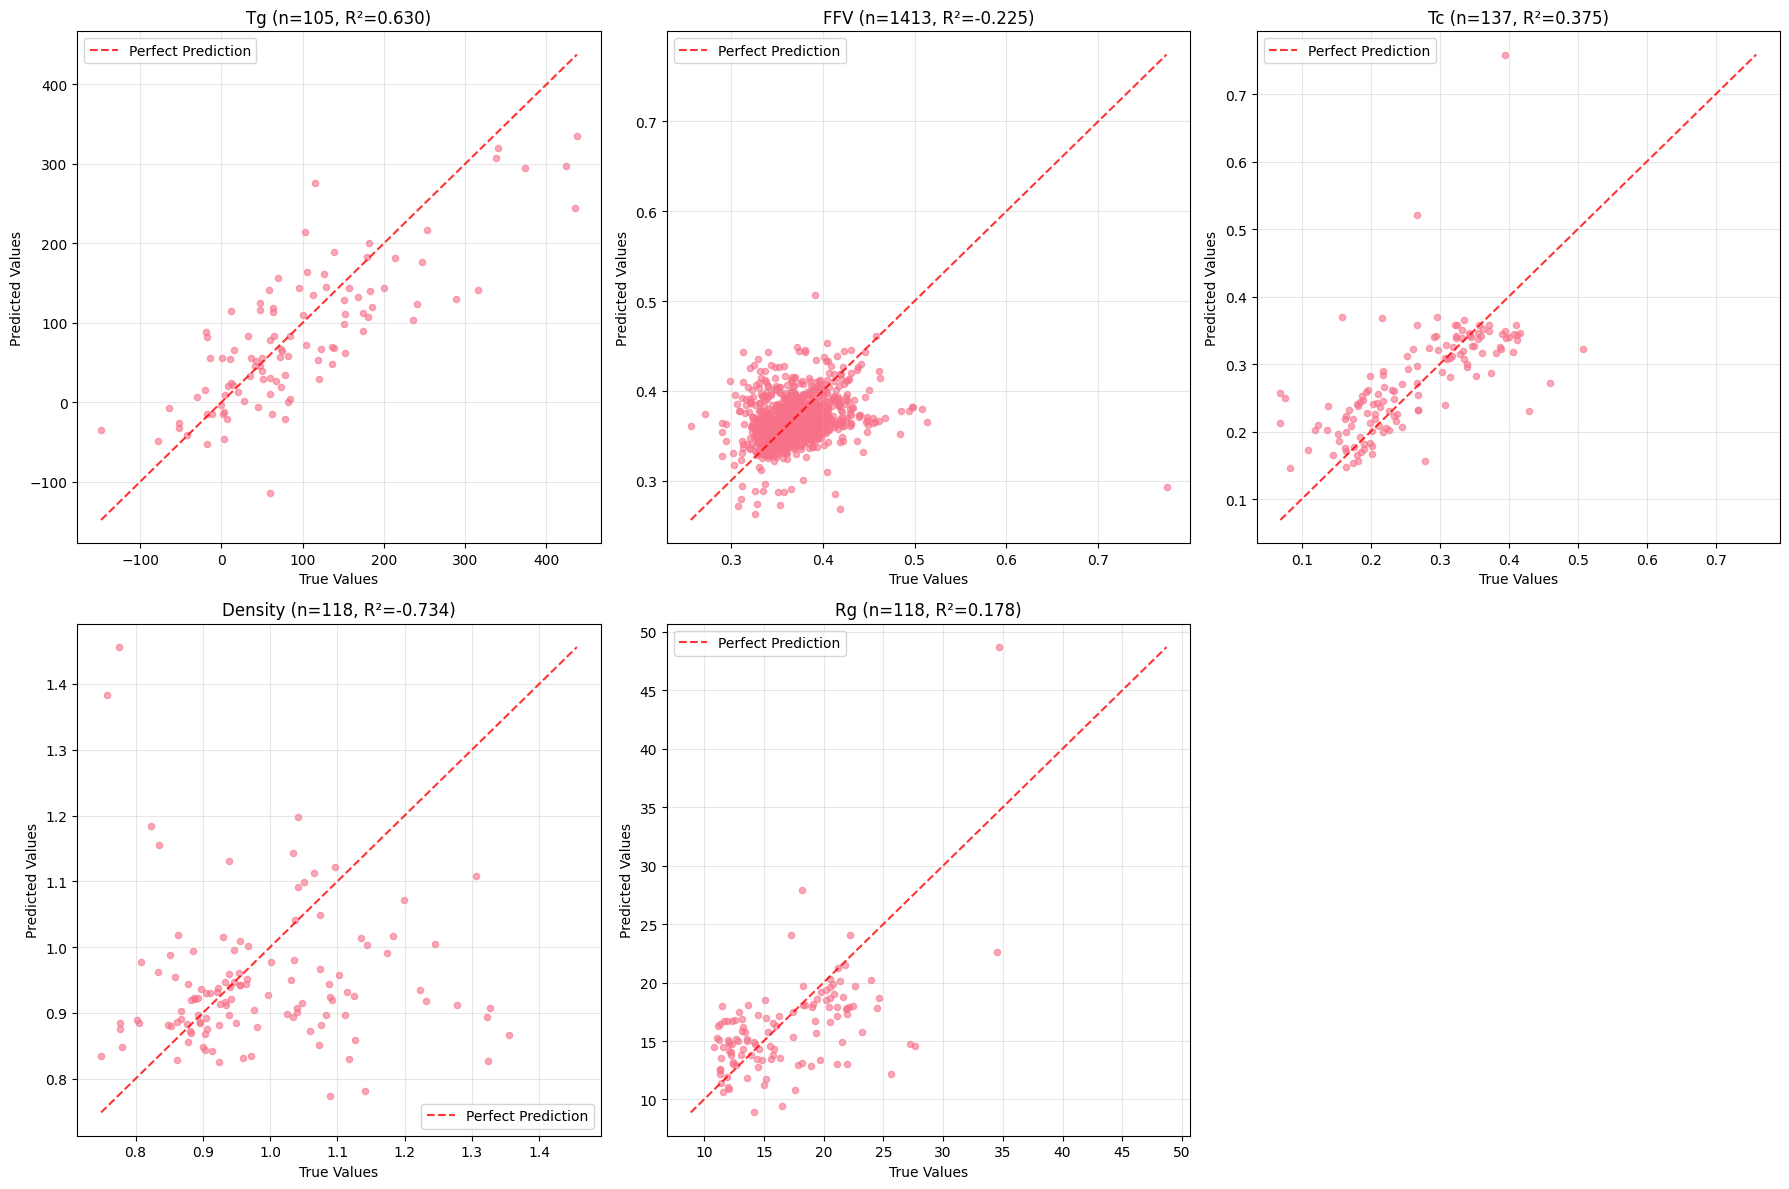

In [24]:
# Analyze prediction distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, prop in enumerate(CONFIG.TARGET_PROPERTIES):
    # Get validation predictions and targets for this property
    prop_mask = val_masks[:, i] == 1
    
    if np.sum(prop_mask) > 0:
        pred_vals = val_preds[prop_mask, i]
        true_vals = val_targets[prop_mask, i]
        
        # Scatter plot: predictions vs targets
        axes[i].scatter(true_vals, pred_vals, alpha=0.6, s=20)
        
        # Perfect prediction line
        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
        
        # Calculate R²
        r2 = 1 - np.sum((true_vals - pred_vals)**2) / np.sum((true_vals - np.mean(true_vals))**2)
        
        axes[i].set_title(f'{prop} (n={len(pred_vals)}, R²={r2:.3f})')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'No data for {prop}', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=axes[i].transAxes, fontsize=14)
        axes[i].set_title(f'{prop} (No Data)')

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

Test Prediction Statistics:


,Tg,FFV,Tc,Density,Rg
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,118.795532,0.351080,0.242574,1.018272,14.625443
std,11.150398,0.010151,0.042662,0.078459,2.926330
min,105.922157,0.342731,0.209780,0.971571,12.585095
25%,115.478951,0.345431,0.218458,0.972981,12.949042
50%,125.035744,0.348131,0.227137,0.974391,13.312989
75%,125.232216,0.355255,0.258972,1.041623,15.645616
max,125.428688,0.362379,0.290806,1.108855,17.978243


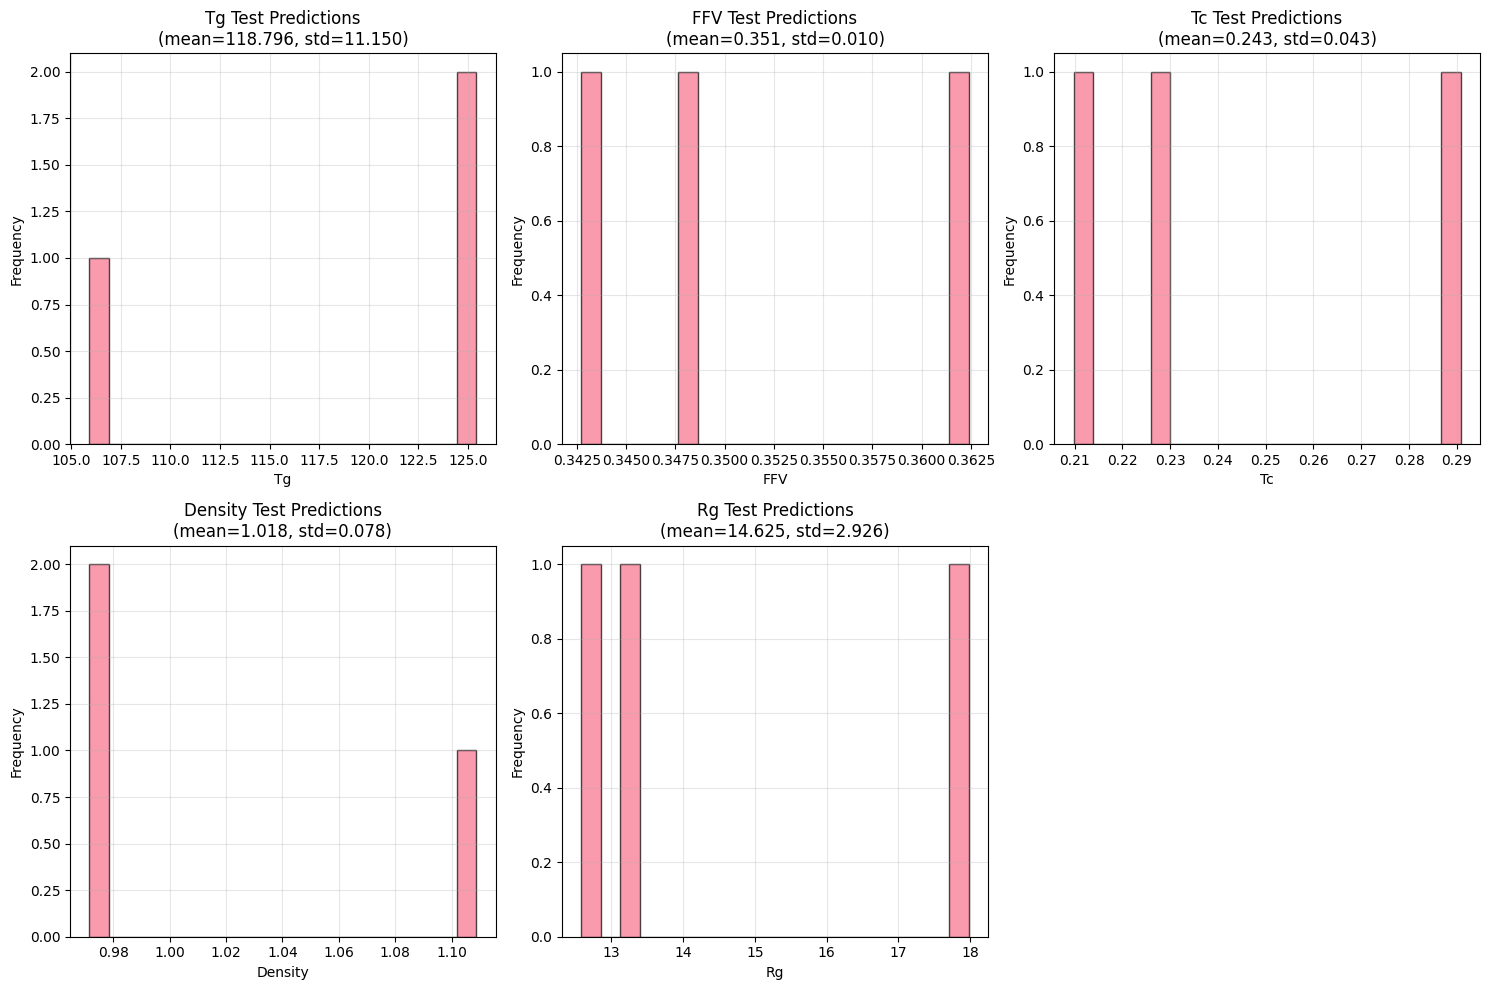

In [25]:
# Analyze test predictions
print("Test Prediction Statistics:")
print("=" * 50)

test_stats = submission_df[CONFIG.TARGET_PROPERTIES].describe()
display(test_stats)

# Plot test prediction distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, prop in enumerate(CONFIG.TARGET_PROPERTIES):
    values = submission_df[prop]
    
    axes[i].hist(values, bins=20, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{prop} Test Predictions\n(mean={values.mean():.3f}, std={values.std():.3f})')
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [26]:
# Summary
print("\n" + "="*80)
print("NEURIPS OPEN POLYMER PREDICTION 2025 - SOLUTION SUMMARY")
print("="*80)
print(f"Model Architecture: Graph Convolutional Network")
print(f"  - Input features: {num_atom_features} atom features")
print(f"  - Hidden channels: {CONFIG.HIDDEN_CHANNELS}")
print(f"  - GCN layers: {CONFIG.NUM_GCN_LAYERS}")
print(f"  - Output: 5 polymer properties")
print(f"  - Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nTraining Configuration:")
print(f"  - Training samples: {len(train_dataset):,}")
print(f"  - Validation samples: {len(val_dataset):,}")
print(f"  - Test samples: {len(test_dataset):,}")
print(f"  - Batch size: {CONFIG.BATCH_SIZE}")
print(f"  - Learning rate: {CONFIG.LEARNING_RATE}")
print(f"  - Epochs trained: {len(history['train_losses'])}")

print(f"\nBest Performance:")
print(f"  - Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"  - Competition wMAE: {checkpoint['wmae']:.6f}")

print(f"\nSubmission:")
print(f"  - File: {submission_filename}")
print(f"  - Format: ✅ Correct")
print(f"  - Ready for upload: ✅ Yes")

print("\nKey Features:")
print("  ✅ Multi-target prediction (5 properties simultaneously)")
print("  ✅ Missing value handling with binary masks")
print("  ✅ Competition metric implementation (weighted MAE)")
print("  ✅ Advanced molecular featurization (26 atom features)")
print("  ✅ Early stopping and learning rate scheduling")
print("  ✅ Comprehensive evaluation and visualization")

print("="*80)
print("🎉 SOLUTION COMPLETE - READY FOR SUBMISSION! 🎉")
print("="*80)


NEURIPS OPEN POLYMER PREDICTION 2025 - SOLUTION SUMMARY
Model Architecture: Graph Convolutional Network
  - Input features: 26 atom features
  - Hidden channels: 128
  - GCN layers: 3
  - Output: 5 polymer properties
  - Parameters: 45,829

Training Configuration:
  - Training samples: 6,378
  - Validation samples: 1,595
  - Test samples: 3
  - Batch size: 32
  - Learning rate: 0.001
  - Epochs trained: 50

Best Performance:
  - Validation Loss: 238.9954
  - Competition wMAE: 0.048804

Submission:
  - File: submission.csv
  - Format: ✅ Correct
  - Ready for upload: ✅ Yes

Key Features:
  ✅ Multi-target prediction (5 properties simultaneously)
  ✅ Missing value handling with binary masks
  ✅ Competition metric implementation (weighted MAE)
  ✅ Advanced molecular featurization (26 atom features)
  ✅ Early stopping and learning rate scheduling
  ✅ Comprehensive evaluation and visualization
🎉 SOLUTION COMPLETE - READY FOR SUBMISSION! 🎉
